In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

get_ipython().magic(u'matplotlib inline')
pd.options.display.max_columns = None
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pprint

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
TEST = True

In [3]:
train = pd.read_csv(r'C:\Users\SkunkWorks\Desktop\ML_Challenege\AnalyticsChallenge1-Train.csv')
test = pd.read_csv(r'C:\Users\SkunkWorks\Desktop\ML_Challenege\AnalyticsChallenge1-Testing.csv')

EmployeeID = test['EmployeeNumber']

In [4]:
train.isnull().values.any()

False

In [5]:
train.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [6]:
train.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,27,No,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1,1244,1,Male,42,3,1,Research Scientist,1,Married,2235,14377,1,Y,Yes,14,3,4,80,2,9,3,2,9,7,6,8
1,31,Yes,Travel_Frequently,667,Sales,1,4,Life Sciences,1,1427,2,Female,50,1,1,Sales Representative,3,Single,1359,16154,1,Y,No,12,3,2,80,0,1,3,3,1,0,0,0
2,38,No,Travel_Rarely,345,Sales,10,2,Life Sciences,1,2041,1,Female,100,3,2,Sales Executive,4,Married,5343,5982,1,Y,No,11,3,3,80,1,10,1,3,10,7,1,9
3,40,Yes,Travel_Rarely,1329,Research & Development,7,3,Life Sciences,1,1649,1,Male,73,3,1,Laboratory Technician,1,Single,2166,3339,3,Y,Yes,14,3,2,80,0,10,3,1,4,2,0,3
4,33,No,Travel_Frequently,827,Research & Development,1,4,Other,1,998,3,Female,84,4,2,Healthcare Representative,2,Married,5488,20161,1,Y,Yes,13,3,1,80,1,6,2,3,6,5,1,2


In [7]:
train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,36.797500,807.315833,9.141667,2.894167,1.0,1014.035833,2.708333,66.108333,2.747500,2.060000,2.740833,6486.90250,14441.413333,2.680000,15.156667,3.145000,2.705833,80.0,0.791667,11.361667,2.800833,2.753333,7.109167,4.270000,2.222500,4.170000
std,9.165779,401.864555,8.103785,1.033048,0.0,605.333838,1.096631,20.341536,0.715894,1.109396,1.090714,4718.58358,7152.650082,2.495888,3.599711,0.352248,1.093296,0.0,0.841935,7.806193,1.294564,0.721981,6.246447,3.664691,3.267806,3.610905
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.00000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,471.000000,2.000000,2.000000,1.0,475.500000,2.000000,48.750000,2.000000,1.000000,2.000000,2935.75000,8199.500000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,35.000000,806.000000,7.000000,3.000000,1.0,1009.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4880.50000,14434.000000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1158.250000,14.000000,4.000000,1.0,1552.500000,4.000000,84.000000,3.000000,3.000000,4.000000,8197.75000,20701.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.250000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.00000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


### Remove features
Drop the features that are clearly not good enough

In [8]:
drop_features = ['Over18', 'EmployeeCount', 'StandardHours']
train = train.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

In [9]:
full_data = [train, test]

### Create new features
Using existing features, assume somethings and merge them

In [10]:
def has_degree(edu):
    return 0 if edu == 1 else 1

def got_promoted(p):
    return 1 if p != 0 else 0

def in_same_company(row):
    if row['YearsAtCompany'] == row['TotalWorkingYears']:
        return 1
    return 0

def in_new_role(row):
    if row['YearsInCurrentRole'] <= 1 and row['YearsInCurrentRole'] != row['YearsAtCompany']:
        return 1
    return 0

def is_with_manager_that_is_new(row):
    if row['YearsWithCurrManager'] <=1 and row['YearsAtCompany'] != row['YearsWithCurrManager']:
        return 1
    return 0

def in_same_role(row):
    if row['YearsInCurrentRole'] == row['YearsAtCompany']:
        return 1
    return 0

def is_with_same_manager(row):
    if row['YearsWithCurrManager'] == row['YearsInCurrentRole']:
        return 1
    return 0

def is_first_ever_job(row):
    if row['NumCompaniesWorked'] == 0:
        return 1
    return 0

def is_employee(row):
    employee_roles = ['Research Scientist',
                      'Laboratory Technician',
                      'Healthcare Representative',
                      'Sales Representative',
                      'Human Resources']
    for role in employee_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_manager(row):
    manager_roles = ['Manager']
    for role in manager_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_executive(row):
    executive_roles = ['Sales Executive']
    for role in executive_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_board(row):
    board_roles = ['Manufacturing Director',
                   'Research Director']
    for role in board_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_promoted(row):
    if row['YearsSinceLastPromotion'] == 1:
        return 1
    return 0

for dataset in full_data:
    
    #hasDegree
    dataset['hasDegree'] = dataset['Education'].apply(has_degree)
    
    #isFirstEverJob
    dataset['isFirstEverJob'] = dataset.apply(lambda row: is_first_ever_job(row), axis=1)
    
    #isSameJob
    dataset['inSameCompany'] = dataset.apply(lambda row: in_same_company(row), axis=1)
    
    #recentlyPromoted
#     dataset['recentlyPromoted'] = dataset.apply(lambda row: is_promoted(row), axis=1)
    
    #isEmployee
    dataset['isEmployee'] = dataset.apply(lambda row: is_employee(row), axis=1)
    
    #isManager
    dataset['isManager'] = dataset.apply(lambda row: is_manager(row), axis=1)
    
    #isExecutive
    dataset['isExecutive'] = dataset.apply(lambda row: is_executive(row), axis=1)
    
    #isBoard
    dataset['isBoard'] = dataset.apply(lambda row: is_board(row), axis=1)
    
    #inSameRole
    dataset['inSameRole'] = dataset.apply(lambda row: in_same_role(row), axis=1)
    
    #withNewRole
    dataset['inNewRole'] = dataset.apply(lambda row: in_new_role(row), axis=1)
    
    #withNewManager
    dataset['withManagerThatIsNew'] = dataset.apply(lambda row: is_with_manager_that_is_new(row), axis=1)
    
    #withSameManager
    dataset['withSameManager'] = dataset.apply(lambda row: is_with_same_manager(row), axis=1)
    
    #doesEduMatchRole

### Normalize data to ordinal values
Now normalize values for algothrims that interpret numbers as ordinal

In [11]:
def normalize_daily_rate(num):
    return int(num / 100)

def normalize_hourly_rate(num):
    return int(num / 10)

def normalize_monthly_income(num):
    return int(num / 1000)

def normalize_monthly_rate(num):
    return int(num / 1000)

train.Attrition = train.Attrition.map({'No':0, 'Yes':1})

for dataset in full_data:
    #Map Age
    dataset.loc[dataset['Age'] <= 25, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35) , 'Age'] = 1
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 45) , 'Age'] = 2
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 55) , 'Age'] = 3
    dataset.loc[dataset['Age'] > 55, 'Age'] = 4
    
#     Map DailyRate
    dataset.loc[:,'DailyRate'] = dataset.loc[:,'DailyRate'].apply(normalize_daily_rate)

    #Map DistanceFromHome
    dataset.loc[dataset['DistanceFromHome'] <= 2, 'DistanceFromHome'] = 0
    dataset.loc[(dataset['DistanceFromHome'] > 2) & (dataset['DistanceFromHome'] <= 5) , 'DistanceFromHome'] = 1
    dataset.loc[(dataset['DistanceFromHome'] > 5) & (dataset['DistanceFromHome'] <= 10) , 'DistanceFromHome'] = 2
    dataset.loc[(dataset['DistanceFromHome'] > 10) & (dataset['DistanceFromHome'] <= 15) , 'DistanceFromHome'] = 3
    dataset.loc[(dataset['DistanceFromHome'] > 15) & (dataset['DistanceFromHome'] <= 20) , 'DistanceFromHome'] = 4
    dataset.loc[(dataset['DistanceFromHome'] > 20) & (dataset['DistanceFromHome'] <= 25) , 'DistanceFromHome'] = 5
    dataset.loc[dataset['DistanceFromHome'] > 25, 'DistanceFromHome'] = 6
    
#     Map HourlyRate
    dataset.loc[:,'HourlyRate'] = dataset.loc[:,'HourlyRate'].apply(normalize_hourly_rate)
    
#     Map MonthlyIncome
    dataset.loc[:,'MonthlyIncome'] = dataset.loc[:,'MonthlyIncome'].apply(normalize_monthly_income)
    
#     Map MonthlyRate
    dataset.loc[:,'MonthlyRate'] = dataset.loc[:,'MonthlyRate'].apply(normalize_monthly_rate)
    
    #Map PercentSalaryHike
    dataset.loc[dataset['PercentSalaryHike'] == 11, 'PercentSalaryHike'] = 0
    dataset.loc[(dataset['PercentSalaryHike'] > 11) & (dataset['PercentSalaryHike'] <= 13) , 'PercentSalaryHike'] = 1
    dataset.loc[(dataset['PercentSalaryHike'] > 13) & (dataset['PercentSalaryHike'] <= 15) , 'PercentSalaryHike'] = 2
    dataset.loc[(dataset['PercentSalaryHike'] > 15) & (dataset['PercentSalaryHike'] <= 17) , 'PercentSalaryHike'] = 3
    dataset.loc[(dataset['PercentSalaryHike'] > 17) & (dataset['PercentSalaryHike'] <= 19) , 'PercentSalaryHike'] = 4
    dataset.loc[(dataset['PercentSalaryHike'] > 19) & (dataset['PercentSalaryHike'] <= 21) , 'PercentSalaryHike'] = 5
    dataset.loc[(dataset['PercentSalaryHike'] > 21) & (dataset['PercentSalaryHike'] <= 23) , 'PercentSalaryHike'] = 6
    dataset.loc[dataset['PercentSalaryHike'] > 23, 'PercentSalaryHike'] = 7
    
    #Map TotalWorkingYears
    dataset.loc[dataset['TotalWorkingYears'] == 0, 'TotalWorkingYears'] = 0
    dataset.loc[(dataset['TotalWorkingYears'] > 0) & (dataset['TotalWorkingYears'] <= 5) , 'TotalWorkingYears'] = 1
    dataset.loc[(dataset['TotalWorkingYears'] > 5) & (dataset['TotalWorkingYears'] <= 10) , 'TotalWorkingYears'] = 2
    dataset.loc[(dataset['TotalWorkingYears'] > 10) & (dataset['TotalWorkingYears'] <= 15) , 'TotalWorkingYears'] = 3
    dataset.loc[(dataset['TotalWorkingYears'] > 15) & (dataset['TotalWorkingYears'] <= 20) , 'TotalWorkingYears'] = 4
    dataset.loc[(dataset['TotalWorkingYears'] > 20) & (dataset['TotalWorkingYears'] <= 25) , 'TotalWorkingYears'] = 5
    dataset.loc[(dataset['TotalWorkingYears'] > 25) & (dataset['TotalWorkingYears'] <= 30) , 'TotalWorkingYears'] = 6
    dataset.loc[(dataset['TotalWorkingYears'] > 30) & (dataset['TotalWorkingYears'] <= 35) , 'TotalWorkingYears'] = 7
    dataset.loc[dataset['TotalWorkingYears'] > 35, 'TotalWorkingYears'] = 8

### Encode columns
Encode categories using one hot encoding to avoid algothrims interpreting numbers as ordinal

In [12]:
one_hot_features = [
                    'BusinessTravel',
                    'Department', 
                    'EducationField', 
                    'JobRole', 
                    'MaritalStatus', 
                    'Gender',
                    'OverTime',
                    'hasDegree',
                    'inSameCompany',
                    'isFirstEverJob',
                    'inNewRole',
                    'inSameRole',
                    'withManagerThatIsNew',
                    'withSameManager',
                    'isEmployee',
                    'isManager',
                    'isExecutive',
                    'isBoard',
#                     'recentlyPromoted',
                    ]

for col in one_hot_features:
    train[col].astype('category')
    test[col].astype('category')
train = pd.get_dummies(train, columns=one_hot_features)
test = pd.get_dummies(test, columns=one_hot_features)

In [13]:
train.shape

(1200, 75)

In [14]:
train.head(20)

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes,hasDegree_0,hasDegree_1,inSameCompany_0,inSameCompany_1,isFirstEverJob_0,isFirstEverJob_1,inNewRole_0,inNewRole_1,inSameRole_0,inSameRole_1,withManagerThatIsNew_0,withManagerThatIsNew_1,withSameManager_0,withSameManager_1,isEmployee_0,isEmployee_1,isManager_0,isManager_1,isExecutive_0,isExecutive_1,isBoard_0,isBoard_1
0,1,0,11,3,3,1244,1,4,3,1,1,2,14,1,2,3,4,2,2,3,2,9,7,6,8,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
1,1,1,6,0,4,1427,2,5,1,1,3,1,16,1,1,3,2,0,1,3,3,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0
2,2,0,3,2,2,2041,1,10,3,2,4,5,5,1,0,3,3,1,2,1,3,10,7,1,9,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
3,2,1,13,2,3,1649,1,7,3,1,1,2,3,3,2,3,2,0,2,3,1,4,2,0,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
4,1,0,8,0,4,998,3,8,4,2,2,5,20,1,1,3,1,1,2,2,3,6,5,1,2,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
5,3,0,2,2,4,1409,3,5,3,1,1,2,17,9,1,3,3,0,3,2,1,5,4,0,4,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0
6,1,0,9,2,3,56,4,3,3,3,3,8,2,1,2,3,4,0,2,0,3,9,8,1,7,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
7,2,0,8,5,5,468,1,4,3,4,4,15,15,2,2,3,2,0,4,2,3,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1
8,1,0,11,2,2,395,4,6,3,1,4,3,4,1,5,4,4,0,1,3,3,5,3,0,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
9,1,0,7,6,1,1859,4,9,1,2,3,6,21,8,3,3,4,2,3,3,3,7,0,1,6,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0


In [15]:
train.columns[train.isnull().any()].tolist()

[]

In [16]:
train.dtypes

Age                                  int64
Attrition                            int64
DailyRate                            int64
DistanceFromHome                     int64
Education                            int64
EmployeeNumber                       int64
EnvironmentSatisfaction              int64
HourlyRate                           int64
JobInvolvement                       int64
JobLevel                             int64
JobSatisfaction                      int64
MonthlyIncome                        int64
MonthlyRate                          int64
NumCompaniesWorked                   int64
PercentSalaryHike                    int64
PerformanceRating                    int64
RelationshipSatisfaction             int64
StockOptionLevel                     int64
TotalWorkingYears                    int64
TrainingTimesLastYear                int64
WorkLifeBalance                      int64
YearsAtCompany                       int64
YearsInCurrentRole                   int64
YearsSinceL

### Correlation and least important features
Drop any correlated features over 0.8
We will keep coming back here and drop unimportant features. Start will the top 5,10,15... least important features

In [17]:

drop_features = [
                      'JobLevel', 
#                       'JobRole_Human Resources',
#                       'Department_Human Resources',
#                       'isManager_0',
#                       'JobRole_Manager',
#                       'EducationField_Human Resources',
#                       'isBoard_1',
#                       'isManager_1',
#                       'isFirstEverJob_1',
#                       'isEmployee_1',
#                       'isEmployee_0',
#                       'isBoard_0', #78%
#                       'isFirstEverJob_0',
#                       'JobRole_Manufacturing Director',
#                       'hasDegree_1',
#                       'PerformanceRating',
#                       'hasDegree_0',
#                       'inNewRole_1',
#                         'MonthlyIncome',
#                       'YearsInCurrentRole',
#                       'YearsWithCurrManager',
#                       'Gender_Female',
#                       'Gender_Male'
#                         'JobRole_Healthcare Representative',
#                         'JobRole_Human Resources',
#                         'JobRole_Laboratory Technician',
#                         'JobRole_Manager',
#                         'JobRole_Manufacturing Director',
#                         'JobRole_Research Director',
#                         'JobRole_Research Scientist',
#                         'JobRole_Sales Executive',
#                         'JobRole_Sales Representative',
#                         'hasDegree'
#                         'Department_Human Resources',
#                         'Department_Research & Development',
#                         'Department_Sales',
                      ]
train = train.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

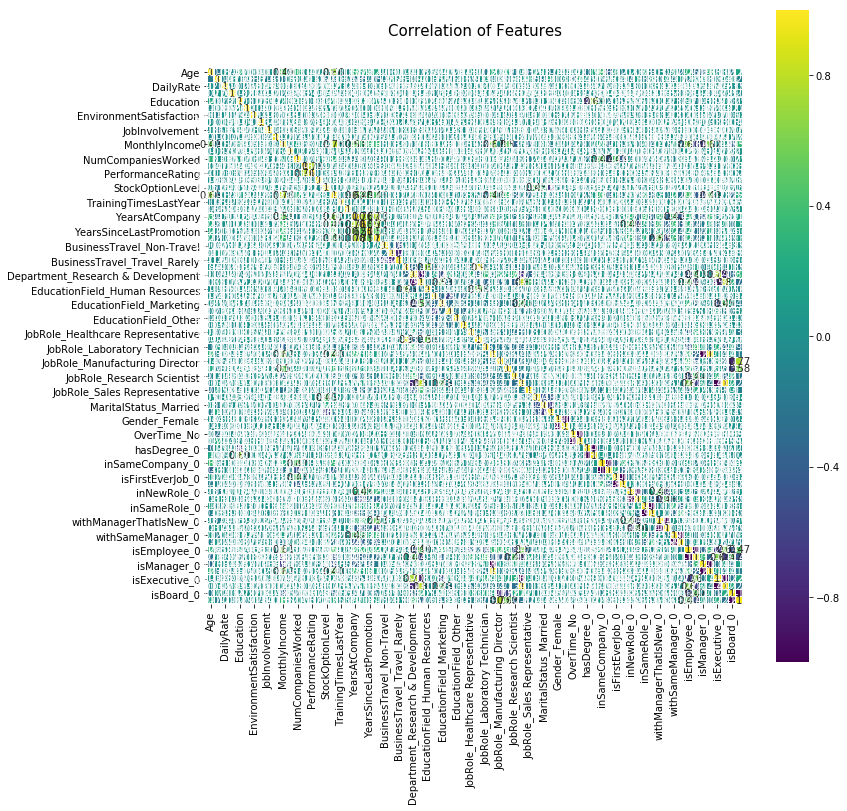

In [18]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y= 1.05, size=15)
sns.heatmap(train.astype(float).corr(), 
            linewidths=0.01, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)

### Learning Helper Class

In [19]:
#Mine
SEED = 0 # for reproducibility
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None):
        if params is not None:
            self.clf = clf(**params)
        else:
            self.clf = clf

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

### Out-of-Fold Predictions Helper Class

In [20]:
#Mine
NFOLDS=10
def get_oof(clf, x_train, y_train, x_test):
    ntrain = len(x_train)
    ntest = len(x_test)
    kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Split for testing

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

m = RFECV(RandomForestClassifier(), scoring='accuracy')
y = train['Attrition'].ravel()
X = train.drop(['Attrition', 'EmployeeNumber'], axis=1)
m.fit(X, y)
# y = train['Attrition'].ravel()
# X = train.drop(['Attrition', 'EmployeeNumber'], axis=1)
# features_columns = list(train.columns.values)
# # features_columns = [.......]
# fs = SelectKBest(chi2, k=21)
# fs.fit_transform(X, y)
# pprint.pprint(list(zip(fs.get_support(),features_columns)))

RFECV(cv=None,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [28]:
print (list(zip(m.get_support(), X.columns.values)))
selected_features = list(zip(m.get_support(), X.columns.values))

[(True, 'Age'), (True, 'DailyRate'), (True, 'DistanceFromHome'), (True, 'Education'), (True, 'EnvironmentSatisfaction'), (True, 'HourlyRate'), (True, 'JobInvolvement'), (True, 'JobSatisfaction'), (True, 'MonthlyIncome'), (True, 'MonthlyRate'), (True, 'NumCompaniesWorked'), (True, 'PercentSalaryHike'), (False, 'PerformanceRating'), (True, 'RelationshipSatisfaction'), (True, 'StockOptionLevel'), (True, 'TotalWorkingYears'), (True, 'TrainingTimesLastYear'), (True, 'WorkLifeBalance'), (True, 'YearsAtCompany'), (True, 'YearsInCurrentRole'), (True, 'YearsSinceLastPromotion'), (True, 'YearsWithCurrManager'), (False, 'BusinessTravel_Non-Travel'), (True, 'BusinessTravel_Travel_Frequently'), (False, 'BusinessTravel_Travel_Rarely'), (False, 'Department_Human Resources'), (False, 'Department_Research & Development'), (True, 'Department_Sales'), (False, 'EducationField_Human Resources'), (False, 'EducationField_Life Sciences'), (False, 'EducationField_Marketing'), (False, 'EducationField_Medical'),

In [30]:
#Mine

if TEST:
#     y = train['Attrition'].ravel()
#     X = train.drop(['Attrition', 'EmployeeNumber'], axis=1)
    
    print (X.shape)
#     fs = SelectKBest(chi2, k=30)
#     fs.fit_transform(X, y)
#     selected_features = list(zip(fs.get_support(),X.columns.values))
    final_features = [x[1] for x in selected_features if x[0] == True]
    X = train[final_features]
#     pprint.pprint(list(zip(fs.get_support(),X.columns.values)))
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    xx = x_train
    x_train = x_train.values # Creates an array of the train data
    x_test = x_test.values # Creates an array of the test data
    print (X.shape)

(1200, 26)
(1200, 26)


In [31]:
if not TEST:
    y_train = train['Attrition'].ravel()
    train = train.drop(['Attrition', 'EmployeeNumber'], axis=1)
    test = test.drop(['EmployeeNumber'], axis=1)
    x_train = train.values # Creates an array of the train data
    x_test = test.values # Creats an array of the test data
    X = x_train
    y = y_train

### Hyper Parameters

In [32]:
# Put in our parameters for said classifiers
# Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
# #      'warm_start': True, 
#      #'max_features': 0.2,
#     'max_depth': 6,
#     'min_samples_leaf': 2,
#     'min_samples_split': 2,
#     'max_features' : 'sqrt',
# #     'verbose': 0
# }

rf_params = {
#     'n_jobs': [-1],
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
#     'max_features' : 'sqrt',
#     'verbose': 0
#             'random_state': [SEED]
}

# Extra Trees Parameters
et_params = {
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
}

# AdaBoost parameters
ada_params = {
    'n_estimators': [120,300,500,800,1200],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.8],
}

# Gradient Boosting parameters
gb_params = {
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
}

# Support Vector Classifier parameters 
svc_params = {
              'kernel' : ['linear'],
              'C' : [0.1, 0.2, 0.5, 0.8, 1, 2],
             }

knn_params = {
              'n_neighbors': [2, 4, 8, 16, 32, 64],
              'p': [2,3],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [2,5,8,10,15,20,35,50]
            }

gbm_params = {            
               'objective': ['binary:logistic'],
               'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
               'n_estimators': [800,1000,1200,2000],
               'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
               'max_depth': [3,4,5,6,7,8,9,10,11,12,13],
               'min_child_weight': [1,2],
               'scale_pos_weight': [0,1],
               'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
               'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
               }

### Tune First-Layer Hyper Parameters
Using the whole dataset, find the best hyperparameters for each model.

In [33]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

RELEARN = True

### K Nearest Neighbors

In [34]:
from sklearn.neighbors import KNeighborsClassifier

if RELEARN:
    knn = KNeighborsClassifier(n_jobs=-1)
    best_knn = RandomizedSearchCV(knn, knn_params, cv=10, scoring='accuracy', n_iter=90, random_state=SEED, n_jobs=-1)
    best_knn.fit(X, y)

    print (best_knn.best_score_)
    print (best_knn.best_estimator_)

0.8358333333333333
KNeighborsClassifier(algorithm='brute', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')


In [35]:
0.8333333333333334
if not RELEARN:
    best_knn = KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='minkowski',
               metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
               weights='uniform')
    best_knn.fit(X, y)

### Support Vector Classifier

In [36]:
if RELEARN:
    svc = SVC(random_state=2)
    best_svc = GridSearchCV(svc, svc_params, cv=10, scoring='accuracy', n_jobs=-1)
    best_svc.fit(X, y)

    print (best_svc.best_score_)
    print (best_svc.best_estimator_)

0.8766666666666667
SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=2, shrinking=True,
  tol=0.001, verbose=False)


In [37]:
# #0.8841666666666667
if not RELEARN:
    best_svc = SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
              max_iter=-1, probability=False, random_state=2, shrinking=True,
              tol=0.001, verbose=False)
    best_svc.fit(X, y)

### Random Forest Classifier

In [38]:
if RELEARN:
    rfc = RandomForestClassifier(n_jobs=-1, random_state=1)
    best_rfc = RandomizedSearchCV(rfc, rf_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=42, n_iter=25)
    best_rfc.fit(X, y)

    print (best_rfc.best_score_)
    print (best_rfc.best_estimator_)

0.8583333333333333
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


In [39]:
# 0.8575
if not RELEARN:
    best_rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
    best_rfc.fit(X, y)

### Extra Trees Classifier

In [40]:
if RELEARN:
    etc = ExtraTreesClassifier(n_jobs=-1, random_state=3)
    best_etc = RandomizedSearchCV(etc, et_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=19, n_iter=25)
    best_etc.fit(X, y)

    print (best_etc.best_score_)
    print (best_etc.best_estimator_)

0.8625
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=15, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)


In [41]:
# 0.8566666666666667
if not RELEARN:
    best_etc = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=8, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)
    best_etc.fit(X, y)

### Ada Boost Classifier

In [42]:
if RELEARN:
    abc = AdaBoostClassifier(random_state=7)
    best_abc = GridSearchCV(abc, ada_params, cv=10, scoring='accuracy', n_jobs=-1)
    best_abc.fit(X, y)

    print (best_abc.best_score_)
    print (best_abc.best_estimator_)

0.8808333333333334
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=120, random_state=7)


In [43]:
# 0.88
if not RELEARN:
    best_abc = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
               learning_rate=0.5, n_estimators=120, random_state=7)
    best_abc.fit(X, y)

### Gradient Boosting Classifier

In [44]:
if RELEARN:
    gbc = GradientBoostingClassifier(random_state=11)
    best_gbc = RandomizedSearchCV(gbc, gb_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=14, n_iter=25)
    # best_gbc = GridSearchCV(gbc, gb_params, cv=10, scoring='accuracy', n_jobs=-1)
    best_gbc.fit(X, y)

    print (best_gbc.best_score_)
    print (best_gbc.best_estimator_)

0.8725
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=11, subsample=1.0, verbose=0,
              warm_start=False)


In [45]:
#0.8841666666666667
if not RELEARN:
    best_gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=250,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=11, subsample=1.0, verbose=0,
              warm_start=False)
    best_gbc.fit(X, y)

### Linear Regression

In [46]:
from sklearn.linear_model import LogisticRegressionCV

if RELEARN: 
    best_lr = LogisticRegressionCV(n_jobs=-1, random_state=5, Cs=3, cv=10, refit=True, class_weight='balanced', max_iter=100)
    best_lr.fit(X, y)

In [47]:
if not RELEARN:
    best_lr = LogisticRegressionCV(Cs=3, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=5,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
    best_lr.fit(X,y)

### XG Boost

In [48]:
if RELEARN:
    xgbc = xgb.XGBClassifier(nthread=-1, seed=71)
    best_xgbc = RandomizedSearchCV(xgbc, gbm_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=SEED, n_iter=25)
    best_xgbc.fit(X, y)

    print (best_xgbc.best_score_)
    print (best_xgbc.best_estimator_)

0.8666666666666667
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=13,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=71, silent=True, subsample=0.9)


In [49]:
# 0.8738095238095238
if not RELEARN:
    best_xgbc = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                   gamma=0.3, learning_rate=0.2, max_delta_step=0, max_depth=13,
                   min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
                   objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                   scale_pos_weight=1, seed=71, silent=True, subsample=0.9)

### Navie Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB

best_nb = GaussianNB()
best_nb.fit(x_train, y_train)

GaussianNB(priors=None)

In [51]:
# Create 5 objects that represent our 4 models
if RELEARN:
    rf = SklearnHelper(clf=best_rfc.best_estimator_, params=None)
    et = SklearnHelper(clf=best_etc.best_estimator_, params=None)
    ada = SklearnHelper(clf=best_abc.best_estimator_, params=None)
    gb = SklearnHelper(clf=best_gbc.best_estimator_, params=None)
    svc = SklearnHelper(clf=best_svc.best_estimator_, params=None)
    knn = SklearnHelper(clf=best_knn.best_estimator_, params=None)
    lr = SklearnHelper(clf=best_lr, params=None)
    xgbc = SklearnHelper(clf=best_xgbc.best_estimator_, params=None)
    nb = SklearnHelper(clf=best_nb, params=None)

In [52]:
if not RELEARN: 
    rf = SklearnHelper(clf=best_rfc, params=None)
    et = SklearnHelper(clf=best_etc, params=None)
    ada = SklearnHelper(clf=best_abc, params=None)
    gb = SklearnHelper(clf=best_gbc, params=None)
    svc = SklearnHelper(clf=best_svc, params=None)
    knn = SklearnHelper(clf=best_knn, params=None)
    lr = SklearnHelper(clf=best_lr, params=None)
    xgbc = SklearnHelper(clf=best_xgbc, params=None)
    nb = SklearnHelper(clf=best_nb, params=None)

### Feature Importances
Create models to suggest which features they feel are important for the entire dataset.

In [53]:
if not TEST:
    rf_feature = rf.feature_importances(x_train,y_train)
    et_feature = et.feature_importances(x_train, y_train)
    ada_feature = ada.feature_importances(x_train, y_train)
    gb_feature = gb.feature_importances(x_train,y_train)
#     svc_feature = svc.fit(X,y).coef_
#     knn_feature = knn.feature_importances(x_train,y_train)
#     xgb_feature = xgbc.feature_importances(x_train,y_train)

In [54]:
if TEST:
    rf_feature = rf.feature_importances(X,y)
    et_feature = et.feature_importances(X, y)
    ada_feature = ada.feature_importances(X, y)
    gb_feature = gb.feature_importances(X,y)
#     svc_feature = svc.fit(X,y).coef_
#     knn_feature = knn.feature_importances(X,y)
#     xgb_feature = gb.feature_importances(X,y)

In [55]:
#Mine
if TEST:
    cols = xx.columns.values
    # Create a dataframe with features
    feature_dataframe = pd.DataFrame({'features': cols,
                                       'Random Forest feature importances': rf_feature,
                                       'Extra Trees feature importances': et_feature,
                                       'AdaBoost feature importances': ada_feature,
                                       'Gradient Boost feature importances': gb_feature,
#                                        'Support Vector feature importances': svc_feature[0],
#                                        'K Nearest Neighbors feature importances': knn_feature,
#                                         'XG Boost feature importances': xgb_feature,
                                      })

In [56]:
if not TEST:
    cols = train.columns.values
    # Create a dataframe with features
    feature_dataframe = pd.DataFrame( {'features': cols,
         'Random Forest feature importances': rf_feature,
         'Extra Trees feature importances': et_feature,
          'AdaBoost feature importances': ada_feature,
        'Gradient Boost feature importances': gb_feature,
#         'Support Vector feature importances': svc_feature[0],
#          'XG Boost feature importances': xgb_feature,
        })

### Plot helper class

In [57]:
def create_scatter_plot(df, feat_key):
    # Scatter plot 
    trace = go.Scatter(
        y = df[feat_key].values,
        x = df['features'].values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = df[feat_key].values,
            colorscale='Portland',
            showscale=True
        ),
        text = feature_dataframe['features'].values
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= feat_key,
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [58]:
create_scatter_plot(feature_dataframe, 'Random Forest feature importances')
create_scatter_plot(feature_dataframe, 'Extra Trees feature importances')
create_scatter_plot(feature_dataframe, 'AdaBoost feature importances')
create_scatter_plot(feature_dataframe, 'Gradient Boost feature importances')
# create_scatter_plot(feature_dataframe, 'Support Vector feature importances')
# create_scatter_plot(feature_dataframe, 'K Nearest Neighbors feature importances')
# create_scatter_plot(feature_dataframe, 'XG Boost feature importances')

In [59]:
# Create the new column containing the average of values
# feature_dataframe = feature_dataframe.drop('Support Vector feature importances',axis=1)
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.sort_values(['mean'], ascending=[False]).head(20)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
8,0.133333,0.048776,0.077625,0.065605,MonthlyIncome,0.081335
17,0.066667,0.041372,0.052662,0.065918,YearsAtCompany,0.056655
4,0.058333,0.052962,0.047058,0.050277,EnvironmentSatisfaction,0.052158
0,0.033333,0.074772,0.044240,0.055591,Age,0.051984
7,0.066667,0.052093,0.041949,0.035710,JobSatisfaction,0.049105
20,0.075000,0.033208,0.047579,0.035491,YearsWithCurrManager,0.047820
10,0.058333,0.038124,0.040606,0.045293,NumCompaniesWorked,0.045589
23,0.033333,0.082412,0.029923,0.034680,MaritalStatus_Single,0.045087
24,0.058333,0.038101,0.030445,0.037358,OverTime_No,0.041060
2,0.033333,0.037859,0.041247,0.046539,DistanceFromHome,0.039745


In [60]:
feature_dataframe.sort_values(['mean'], ascending=[True]).head(20)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
3,0.000000,0.016384,0.019496,0.023258,Education,0.014784
5,0.000000,0.021215,0.023751,0.035075,HourlyRate,0.020010
14,0.000000,0.035727,0.027110,0.025274,TotalWorkingYears,0.022028
11,0.025000,0.021791,0.027868,0.035980,PercentSalaryHike,0.027660
15,0.025000,0.025631,0.035515,0.035674,TrainingTimesLastYear,0.030455
18,0.033333,0.034826,0.029606,0.024796,YearsInCurrentRole,0.030640
21,0.033333,0.044990,0.022955,0.024691,BusinessTravel_Travel_Frequently,0.031492
16,0.025000,0.040310,0.028422,0.032248,WorkLifeBalance,0.031495
9,0.000000,0.021726,0.058692,0.051616,MonthlyRate,0.033008
13,0.025000,0.028239,0.038565,0.041332,StockOptionLevel,0.033284


In [61]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### First-Level Training

In [62]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
knn_oof_train, knn_oof_test = get_oof(knn, x_train, y_train, x_test) # K Nearest Neighbor
lr_oof_train, lr_oof_test = get_oof(lr, x_train, y_train, x_test) # Linear Regression
xgbc_oof_train, xgbc_oof_test = get_oof(xgbc, x_train, y_train, x_test) # xg Boost
nb_oof_train, nb_oof_test = get_oof(nb, x_train, y_train, x_test) # Naive Bayes

### Second-Level Predictions based on First-Level Output

In [63]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel(),
                                        'SupportVector': svc_oof_train.ravel(),
                                        'KNearestNeighbors': knn_oof_train.ravel(),
                                        'LinearRegression': lr_oof_train.ravel(),
                                        'XGBoost': xgbc_oof_train.ravel(),
                                        'NaiveBayes': nb_oof_train.ravel(),
    })
base_predictions_train.head(20)

,AdaBoost,ExtraTrees,GradientBoost,KNearestNeighbors,LinearRegression,NaiveBayes,RandomForest,SupportVector,XGBoost
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
base_predictions_train.tail(20)

,AdaBoost,ExtraTrees,GradientBoost,KNearestNeighbors,LinearRegression,NaiveBayes,RandomForest,SupportVector,XGBoost
820,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
821,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
823,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
825,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
826,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Heatmap of Second-Level Training

In [65]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [66]:
x_train = np.concatenate((
                          et_oof_train, 
                          rf_oof_train, 
                          ada_oof_train, 
                          gb_oof_train, 
                          svc_oof_train,
                          lr_oof_train,
                          knn_oof_train,
                          xgbc_oof_train,
                          nb_oof_train,
                         ), axis=1)
x_test = np.concatenate(( 
                          et_oof_test, 
                          rf_oof_test, 
                          ada_oof_test, 
                          gb_oof_test, 
                          svc_oof_test,
                          lr_oof_test,
                          knn_oof_test,
                          xgbc_oof_test,
                          nb_oof_test,
                        ), axis=1)

### Find Second-Layer hyper-parameters

In [67]:
# gbm_params = {            
#                'objective': ['binary:logistic'],
#                'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
#                'n_estimators': [800,1000,1200,2000],
#                'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
#                'max_depth': [3,4,5,6,7,8,9,10,11,12,13],
#                'min_child_weight': [1,2],
#                'scale_pos_weight': [0,1],
#                'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
#                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
#                }

In [68]:
if RELEARN:
    gbm = xgb.XGBClassifier(nthread=-1, seed=17)
    best_gbm = RandomizedSearchCV(gbm, gbm_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=88, n_iter=50)
    best_gbm.fit(x_train, y_train)

    print (best_gbm.best_score_)
    print (best_gbm.best_estimator_)

0.8797619047619047
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.3, learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=800, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=17, silent=True, subsample=0.6)


In [69]:
#0.8775
if not RELEARN:
    best_gbm = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
           gamma=0.1, learning_rate=0.4, max_delta_step=0, max_depth=10,
           min_child_weight=2, missing=None, n_estimators=1200, nthread=-1,
           objective='binary:logistic', reg_alpha=0, reg_lambda=1,
           scale_pos_weight=1, seed=17, silent=True, subsample=0.8)
    best_gbm.fit(x_train, y_train)

In [70]:
predictions = best_gbm.predict(x_test)

In [71]:
if TEST:
    print ("{0}".format(metrics.confusion_matrix(y_test, predictions)))
    print ('')
    print (metrics.classification_report(y_test, predictions))

[[295  11]
 [ 27  27]]

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       306
          1       0.71      0.50      0.59        54

avg / total       0.89      0.89      0.89       360



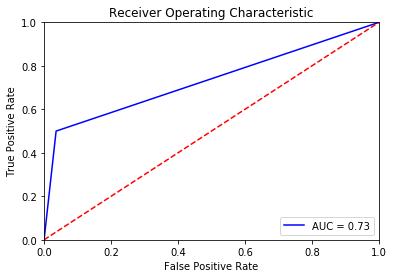

In [72]:
if TEST:
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [73]:
if not TEST:
    StackingSubmission = pd.DataFrame({ 'EmployeeNumber': EmployeeID,
                                        'Attrition': predictions })
    StackingSubmission.to_csv(r"C:\Users\SkunkWorks\Desktop\ML_Challenege\Submission.csv", index=False)